In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(str(Path().resolve().parent))
from scripts.pref_generator import generate_preferences
from paths import SCHEDULES, ASSIGNMENTS, PREFERENCES

In [2]:
PLAN_PATH = SCHEDULES / "single_subject_x2.csv"
ASSIGN_PATH = ASSIGNMENTS / "single_subject_x2.csv"
TIME_FMT = "%H:%M"

In [3]:
plan = pd.read_csv(PLAN_PATH, sep=None, engine="python")
plan_2 = plan[["subject", "group_id", "day", "start_time"]].copy()
assign = pd.read_csv(ASSIGN_PATH, sep=None, engine="python")

In [4]:
import numpy.ma as ma


def plot_prefrences(plan: pd.DataFrame, prefs, ax=None):
    merged = prefs.merge(plan, on=["subject", "group_id"], how="left")

    time_parsed = pd.to_datetime(merged["start_time"], format=TIME_FMT)
    merged["minute"] = time_parsed.dt.hour * 60 + time_parsed.dt.minute

    days_order = ["Pn", "Wt", "Sr", "Cz", "Pt"]
    # unique_minutes = sorted(merged['minute'].unique())
    unique_minutes = [
        np.int32(480),
        np.int32(585),
        np.int32(690),
        np.int32(795),
        np.int32(900),
        np.int32(1005),
        np.int32(1110),
    ]

    heat = np.zeros((len(days_order), len(unique_minutes)), dtype=int)
    group_ids = [[set() for _ in unique_minutes] for _ in days_order]

    for _, _stu, subj, gid, pref, day, _t, minute in merged.itertuples():
        if day in days_order:
            d_idx = days_order.index(day)
            t_idx = unique_minutes.index(minute)
            heat[d_idx, t_idx] += pref
            group_ids[d_idx][t_idx].add((subj, gid))

    for d_idx in range(len(days_order)):
        for t_idx in range(len(unique_minutes)):
            group_count = len(group_ids[d_idx][t_idx])
            if group_count > 0:
                heat[d_idx, t_idx] /= group_count

    if ax is None:
        _fig, ax = plt.subplots(figsize=(10, 6))

    nonzero_vals = heat[heat > 0]
    vmin = nonzero_vals.min() if len(nonzero_vals) else 0
    vmax = nonzero_vals.max() if len(nonzero_vals) else 1

    masked = ma.masked_where(heat == 0, heat)
    _im = ax.imshow(masked.T, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(-0.5, len(days_order), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(unique_minutes), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # osie
    ax.set_xticks(range(len(days_order)))
    ax.set_xticklabels(days_order)

    def minute_to_str(m):
        h, mi = divmod(m, 60)
        return f"{int(h):02d}:{int(mi):02d}"

    time_labels = [minute_to_str(m) for m in unique_minutes]
    ax.set_yticks(range(len(unique_minutes)))
    ax.set_yticklabels(time_labels)

    # ax.set_xlabel("Dzień tygodnia")
    # ax.set_ylabel("Godzina rozpoczęcia")

    # Wartości w komórkach
    for x in range(len(days_order)):
        for y in range(len(unique_minutes)):
            if heat[x, y] != 0:
                ax.text(
                    x,
                    y,
                    heat[x, y],
                    ha="center",
                    va="center",
                    color="w" if heat[x, y] < heat.max() / 2 else "black",
                )

    return ax

In [5]:
df = generate_preferences(plan, assign, noise_sigma=0.1)
counts = df["preference"].value_counts(dropna=False).sort_index()
print(counts)

preference
0       5
1      21
2      76
3     161
4     318
5     437
6     556
7     546
8     502
9     423
10    455
Name: count, dtype: int64


<Axes: >

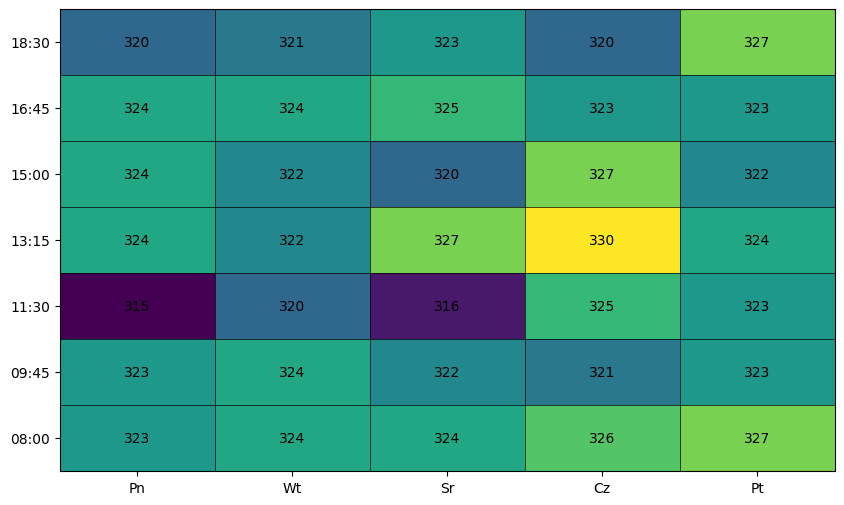

In [6]:
WEIGHTS = {
    "day": {"Pn": 0.5, "Wt": 0.5, "Sr": 0.5, "Cz": 0.5, "Pt": 0.5},
    "hour": {
        "08:00": 0.5,
        "09:45": 0.5,
        "11:30": 0.5,
        "13:15": 0.5,
        "15:00": 0.5,
        "16:45": 0.5,
        "18:30": 0.5,
    },
    "teacher": {
        "Prowadzący-10": 0.6,
        "Prowadzący-9": 0.6,
    },
}

prefs = generate_preferences(plan, assign, weights=WEIGHTS)
plot_prefrences(plan_2, prefs)

preference
6        2
7       76
8      384
9      740
10    2298
Name: count, dtype: int64


<Axes: >

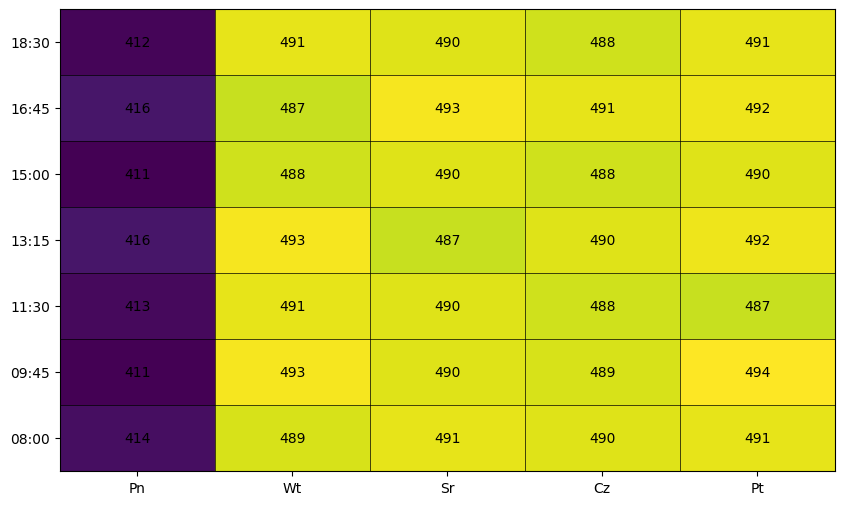

In [7]:
WEIGHTS = {
    "day": {"Pn": 0.1, "Wt": 1.0, "Sr": 1.0, "Cz": 1.0, "Pt": 1.0},
    "hour": {
        "08:00": 1.0,
        "09:45": 1.0,
        "11:30": 1.0,
        "13:15": 1.0,
        "15:00": 1.0,
        "16:45": 1.0,
        "18:30": 1.0,
    },
    "teacher": {
        "Prowadzący‑1": 0.6,
        "Prowadzący‑2": 0.6,
    },
}
prefs = generate_preferences(plan, assign, weights=WEIGHTS)
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_2, prefs)

preference
4     350
6    2800
8     350
Name: count, dtype: int64


<Axes: >

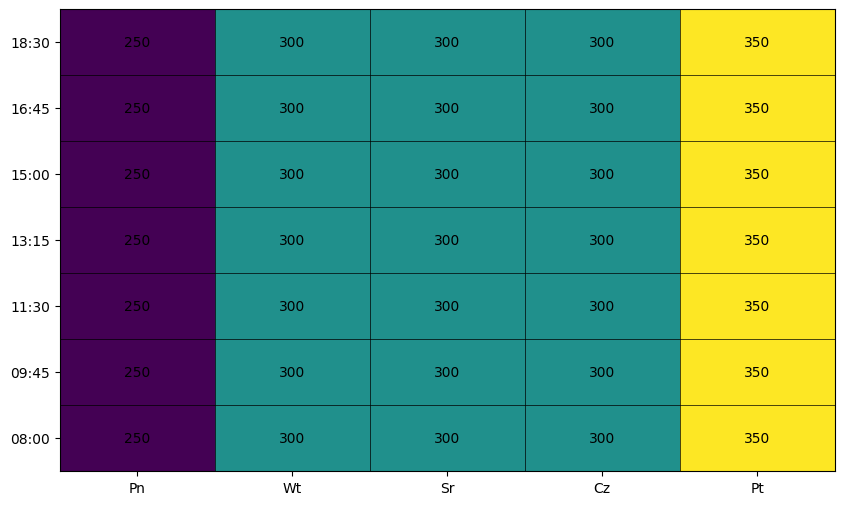

In [8]:
WEIGHTS = {
    "day": {"Pn": 0.5, "Wt": 0.5, "Sr": 0.5, "Cz": 0.5, "Pt": 0.5},
    "hour": {
        "08:00": 0.5,
        "09:45": 0.5,
        "11:30": 0.5,
        "13:15": 0.5,
        "15:00": 0.5,
        "16:45": 0.5,
        "18:30": 0.5,
    },
    "teacher": {
        "Prowadzący-1": 0.1,
        "Prowadzący-18": 1.0,
    },
}
prefs = generate_preferences(plan, assign, noise_sigma=0.0, weights=WEIGHTS)
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_2, prefs)

preference
0     611
1     145
2     196
3     189
4     244
5     253
6     231
7     244
8     212
9     225
10    950
Name: count, dtype: int64


<Axes: >

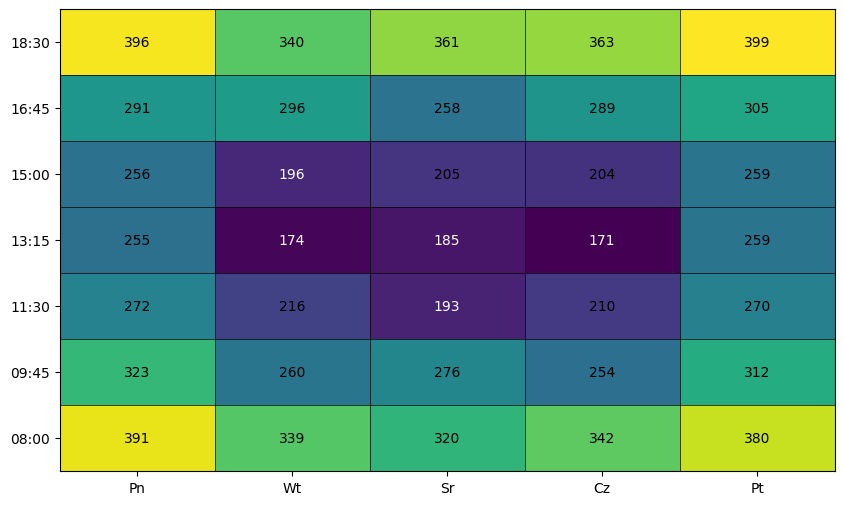

In [9]:
WEIGHTS = {
    "day": {"Pn": 1.0, "Wt": 0.1, "Sr": 0.0, "Cz": 0.1, "Pt": 1.0},
    "hour": {
        "08:00": 1.0,
        "09:45": 0.5,
        "11:30": 0.1,
        "13:15": 0.0,
        "15:00": 0.1,
        "16:45": 0.5,
        "18:30": 1.0,
    },
    "teacher": {
        "Prowadzący‑1": 0.6,
        "Prowadzący‑2": 0.6,
    },
}
prefs = generate_preferences(plan, assign, noise_sigma=0.4, weights=WEIGHTS)
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_2, prefs)

preference
0      675
1      137
2      126
3      176
4      157
5      174
6      174
7      199
8      184
9      171
10    1327
Name: count, dtype: int64


<Axes: >

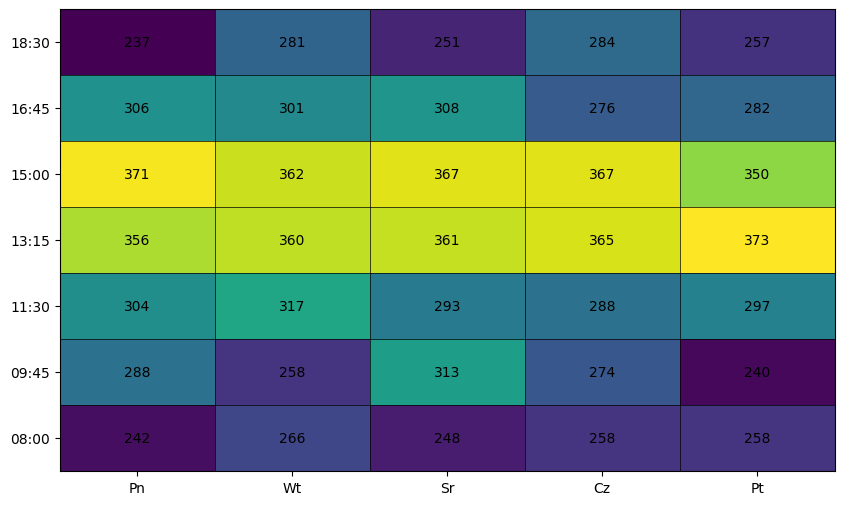

In [10]:
WEIGHTS = {
    "day": {"Pn": 1.0, "Wt": 1.0, "Sr": 1.0, "Cz": 1.0, "Pt": 1.0},
    "hour": {
        "08:00": 0.1,
        "09:45": 0.3,
        "11:30": 0.5,
        "13:15": 1.0,
        "15:00": 1.0,
        "16:45": 0.4,
        "18:30": 0.1,
    },
    "teacher": {
        "Prowadzący‑1": 0.6,
        "Prowadzący‑2": 0.6,
    },
}
prefs = generate_preferences(plan, assign, noise_sigma=0.5, weights=WEIGHTS)
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_2, prefs)

preference
0      657
1      141
2      131
3      182
4      194
5      192
6      214
7      194
8      187
9      176
10    1232
Name: count, dtype: int64


<Axes: >

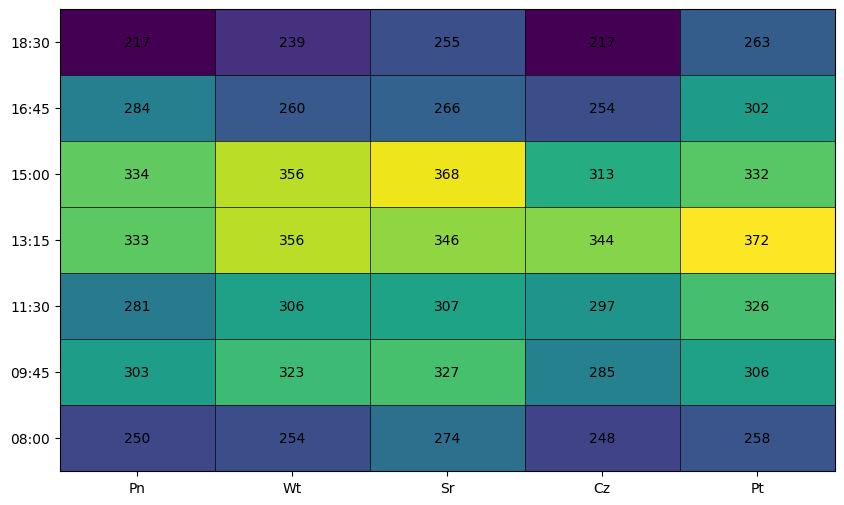

In [11]:
WEIGHTS = {
    "day": {"Pn": 0.5, "Wt": 0.8, "Sr": 0.9, "Cz": 0.6, "Pt": 0.4},
    "hour": {
        "08:00": 0.1,
        "09:45": 0.5,
        "11:30": 0.6,
        "13:15": 0.9,
        "15:00": 0.8,
        "16:45": 0.4,
        "18:30": 0.1,
    },
    "teacher": {
        "Prowadzący-18": 0.9,
        "Prowadzący-17": 0.9,
    },
}
prefs = generate_preferences(plan, assign, noise_sigma=0.5, weights=WEIGHTS)
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_2, prefs)

In [17]:
plan2 = pd.read_csv(SCHEDULES / "schedule_1.csv", sep=None, engine="python")
plan2 = plan2[plan2["type"] != "W"].copy()
plan_3 = plan2[["subject", "group_id", "day", "start_time"]].copy()
assign2 = pd.read_csv(
    ASSIGNMENTS / "subject_assignment_1.csv", sep=None, engine="python"
)

preference
0     6348
1      213
2      184
3      194
4      201
5      170
6      190
7      188
8      184
9      153
10    5655
Name: count, dtype: int64


<Axes: >

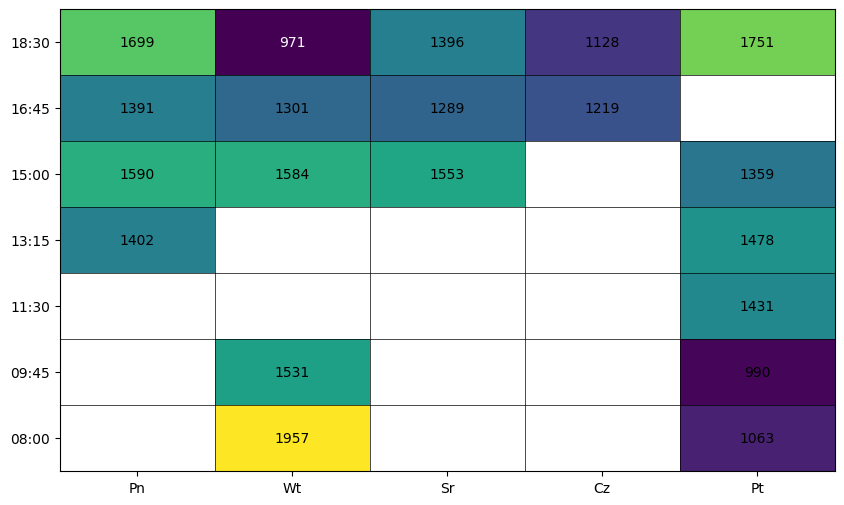

In [18]:
WEIGHTS = {
    "day": {"Pn": 2.0, "Wt": 1.5, "Sr": 0.0, "Cz": 0.1, "Pt": -1.0},
    "hour": {
        "08:00": -2.0,
        "09:45": -1.5,
        "11:30": -1.0,
        "13:15": 0.5,
        "15:00": 1.5,
        "16:45": 0,
        "18:30": -2.5,
    },
    "teacher": {
        "Prowadzący-1": 0.9,
        "Prowadzący-9": 0.5,
    },
}

prefs = generate_preferences(plan2, assign2, noise_sigma=2, weights=WEIGHTS, )
counts = prefs["preference"].value_counts(dropna=False).sort_index()
print(counts)
plot_prefrences(plan_3, prefs)

In [19]:
prefs.to_csv(PREFERENCES / "prefs_1.csv", index=False)

In [20]:
def plot_prefrences_per_subject(plan, prefs):
    subjects = plan["subject"].unique()
    n = len(subjects)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    _fig, axes = plt.subplots(
        nrows, ncols, figsize=(4 * ncols, 3 * nrows), squeeze=False
    )
    for ax in axes.flat[n:]:
        ax.axis("off")

    for i, subj in enumerate(subjects):
        plan_subj = plan[plan["subject"] == subj].copy()
        ax = axes.flat[i]
        axes.flat[i] = plot_prefrences(plan_subj, prefs[prefs["subject"] == subj], ax)
        ax.set_title(f"{subj}")

    plt.tight_layout()
    plt.show()

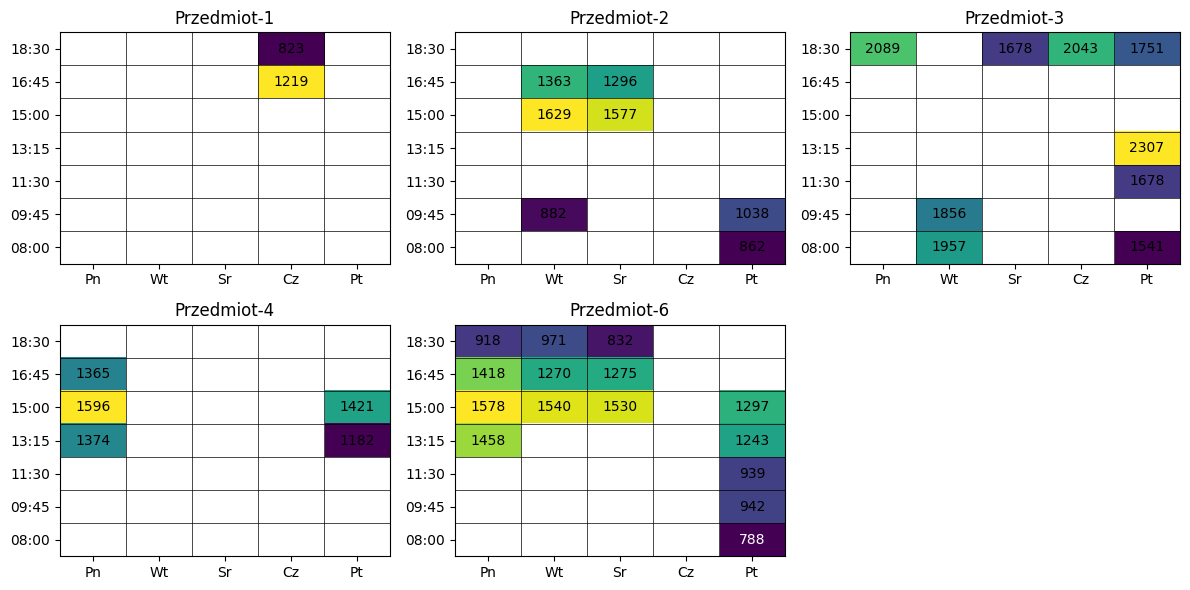

In [21]:
plot_prefrences_per_subject(plan_3, prefs)